In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [23]:
Image_Size = 256
Batch_Size = 36

In [24]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Dexterix 3.0\model\Grapes Dataset",
    shuffle = True,
    image_size = (Image_Size, Image_Size),
    batch_size = Batch_Size 
)

Found 1000 files belonging to 4 classes.


In [25]:
class_name = dataset.class_names
class_name

['Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy']

In [26]:
len(dataset)

28

(36, 256, 256, 3)
[0 1 2 3 3 2 3 2 1 2 1 2 3 2 3 0 3 3 0 3 2 3 0 0 0 3 1 1 3 3 3 1 0 0 2 2]


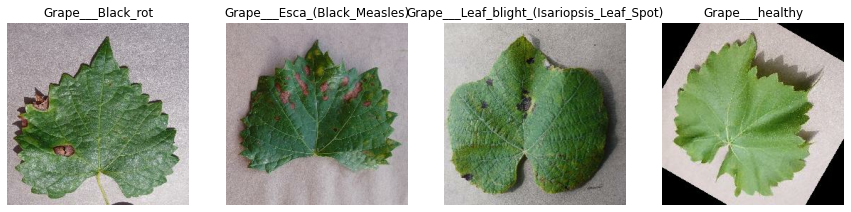

In [27]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    plt.figure(figsize=(15, 15))
    for i in range(4):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])
        plt.axis("off")

In [28]:
train_size = 0.8
len(dataset)*train_size

22.400000000000002

In [29]:
train_ds = dataset.take(22)
len(train_ds)

22

In [30]:
test_ds = dataset.skip(22)
len(test_ds)

6

In [31]:
val_size=0.1
len(dataset)*val_size

2.8000000000000003

In [32]:
val_ds = test_ds.take(2)
len(val_ds)

2

In [33]:
test_ds = test_ds.skip(2)
len(test_ds)

4

In [34]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds 

In [35]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [36]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [37]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(Image_Size, Image_Size),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [38]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [39]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [40]:
input_shape = (Batch_Size, Image_Size, Image_Size, 3)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])

model.build(input_shape=input_shape)


In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (40, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (40, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (40, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (40, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (40, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (40, 60, 60, 64)         

In [41]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [42]:
history = model.fit(
    train_ds,
    batch_size=Batch_Size,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
)

Epoch 1/100
22/22 [==============================] - 35s 1s/step - loss: 1.3530 - accuracy: 0.3112 - val_loss: 1.1894 - val_accuracy: 0.3889
Epoch 2/100
22/22 [==============================] - 33s 1s/step - loss: 1.1462 - accuracy: 0.4974 - val_loss: 0.9065 - val_accuracy: 0.5972
Epoch 3/100
22/22 [==============================] - 35s 2s/step - loss: 0.8950 - accuracy: 0.6161 - val_loss: 0.8258 - val_accuracy: 0.6389
Epoch 4/100
22/22 [==============================] - 37s 2s/step - loss: 0.7118 - accuracy: 0.7092 - val_loss: 0.8550 - val_accuracy: 0.6806
Epoch 5/100
22/22 [==============================] - 41s 2s/step - loss: 0.6644 - accuracy: 0.7372 - val_loss: 0.8914 - val_accuracy: 0.6806
Epoch 6/100
22/22 [==============================] - 41s 2s/step - loss: 0.7078 - accuracy: 0.7219 - val_loss: 0.7167 - val_accuracy: 0.6528
Epoch 7/100
22/22 [==============================] - 36s 2s/step - loss: 0.5476 - accuracy: 0.7628 - val_loss: 0.6673 - val_accuracy: 0.6528
Epoch 8/100
2

Epoch 59/100
22/22 [==============================] - 38s 2s/step - loss: 0.0855 - accuracy: 0.9656 - val_loss: 0.4505 - val_accuracy: 0.8750
Epoch 60/100
22/22 [==============================] - 38s 2s/step - loss: 0.0922 - accuracy: 0.9745 - val_loss: 0.1667 - val_accuracy: 0.9444
Epoch 61/100
22/22 [==============================] - 35s 2s/step - loss: 0.0232 - accuracy: 0.9962 - val_loss: 0.1514 - val_accuracy: 0.9583
Epoch 62/100
22/22 [==============================] - 37s 2s/step - loss: 0.0327 - accuracy: 0.9911 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 63/100
22/22 [==============================] - 38s 2s/step - loss: 0.0350 - accuracy: 0.9898 - val_loss: 0.1067 - val_accuracy: 0.9722
Epoch 64/100
22/22 [==============================] - 41s 2s/step - loss: 0.0419 - accuracy: 0.9860 - val_loss: 0.0880 - val_accuracy: 0.9444
Epoch 65/100
22/22 [==============================] - 41s 2s/step - loss: 0.0436 - accuracy: 0.9860 - val_loss: 0.0543 - val_accuracy: 0.9861
Epoch 

In [43]:
scores = model.evaluate(test_ds)

4/4 [==============================] - 5s 365ms/step - loss: 0.0451 - accuracy: 0.9931


In [44]:
import numpy as np
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

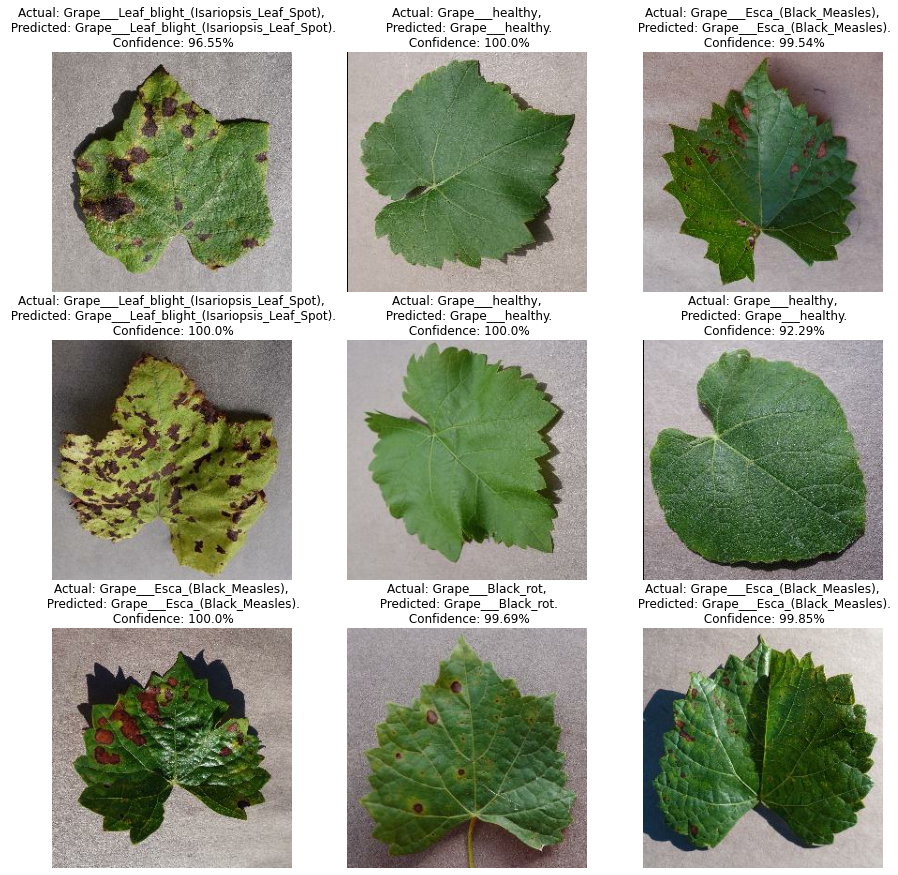

In [45]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [46]:
model.save(f"D:\Dexterix 3.0\model{4}")

INFO:tensorflow:Assets written to: D:\Dexterix 3.0\model4\assets
